In [63]:
import pandas as pd
import numpy as np
import scipy
import plotly.express as px
import plotly.graph_objects as go
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go
from datetime import datetime
import statsmodels
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from pygam import LinearGAM, s, f, l
from prophet import Prophet

In [ ]:
# Data Importing

data = pd.read_csv("https://github.com/dustywhite7/Econ8310/raw/master/DataSets/RecessionForecasting.csv")
data['DATE'] = pd.to_datetime(data['DATE'])

px.line(data, x="DATE", y='CivEmpLevel')

In [9]:

## Simple Exponential Smoothing

employment = data['CivEmpLevel']
employment.index = data['DATE']
employment.index.freq = employment.index.inferred_freq

alpha020 = SimpleExpSmoothing(employment).fit(
                                        smoothing_level=0.2,
                                        optimized=False)

alpha050 = SimpleExpSmoothing(employment).fit(
                                        smoothing_level=0.5,
                                        optimized=False)

alpha080 = SimpleExpSmoothing(employment).fit(
                                        smoothing_level=0.8,
                                        optimized=False)

forecast020 = alpha020.forecast(3)
forecast050 = alpha050.forecast(3)
forecast080 = alpha080.forecast(3)

# Plotting our data

smoothData = pd.DataFrame([employment.values, alpha020.fittedvalues.values,  alpha050.fittedvalues.values,  alpha080.fittedvalues.values]).T
smoothData.columns = ['Truth', 'alpha=0.2', 'alpha=0.5', 'alpha=0.8']
smoothData.index = employment.index

fig = px.line(smoothData, y = ['Truth', 'alpha=0.2', 'alpha=0.5', 'alpha=0.8'], 
        x = smoothData.index,
        color_discrete_map={"Truth": 'blue',
                           'alpha=0.2': 'red', 
                            'alpha=0.5':'green', 
                            'alpha=0.8':'purple'}
       )

fig.update_xaxes(range=[smoothData.index[-50], forecast020.index[-1]])
fig.update_yaxes(range=[142000, 153000])


# Incorporating the Forecasts

fig.add_trace(go.Scatter(x=forecast020.index, y = forecast020.values, name='Forecast alpha=0.2', line={'color':'red'}))
fig.add_trace(go.Scatter(x=forecast050.index, y = forecast050.values, name='Forecast alpha=0.5', line={'color':'green'}))
fig.add_trace(go.Scatter(x=forecast080.index, y = forecast080.values, name='Forecast alpha=0.8', line={'color':'purple'}))

In [17]:
# Best Fitting Model 
alphaBest = SimpleExpSmoothing(employment).fit()
forecast = alphaBest.forecast(3)

smoothData = pd.DataFrame([employment.values, alphaBest.fittedvalues.values]).T
smoothData.columns = ['Truth', 'Best Fit Model']
smoothData.index = employment.index

fig = px.line(smoothData, y = ['Truth', 'Best Fit Model'], 
        x = smoothData.index,
        color_discrete_map={"Truth": 'blue',
                           'Best Fit Model': 'red'}
       )

fig.update_xaxes(range=[smoothData.index[-50], forecast.index[-1]])
fig.update_yaxes(range=[142000, 153000])

fig.add_trace(go.Scatter(x=forecast.index, y = forecast.values, name='Forecast', line={'color':'red'}))

In [20]:
## Holt’s Linear Trend Method & Damped Trend Model

# Linear trend
trend = ExponentialSmoothing(employment, trend='add').fit()
# Linear trend with damping
dampedTrend = ExponentialSmoothing(employment, trend='add', damped=True, use_boxcox=True).fit(use_brute=True)
forecast_t = trend.forecast(10)
forecast_dt = dampedTrend.forecast(10)

# Plotting our data

smoothData = pd.DataFrame([employment.values, trend.fittedvalues.values, dampedTrend.fittedvalues.values]).T
smoothData.columns = ['Truth', 'Trend', 'Damped Trend']
smoothData.index = employment.index

fig = px.line(smoothData, y = ['Truth', 'Trend', 'Damped Trend'], 
        x = smoothData.index,
        color_discrete_map={"Truth": 'blue',
                           'Trend': 'red',
                            'Damped Trend': 'green'
                           },
              title='Linear and Damped Trends'
       )

fig.update_xaxes(range=[smoothData.index[-50], forecast_t.index[-1]])
fig.update_yaxes(range=[142000, 154000])


# Incorporating the Forecasts

fig.add_trace(go.Scatter(x=forecast_t.index, y = forecast_t.values, name='Forecast Trend', line={'color':'red'}))
fig.add_trace(go.Scatter(x=forecast_dt.index, y = forecast_dt.values, name='Forecast Damped Trend', line={'color':'green'}))

<positron-console-cell-20>:6: FutureWarning:

the 'damped' keyword is deprecated, use 'damped_trend' instead.



In [22]:
## Holt-Winters’ Seasonal Method

# Linear trend
trend = ExponentialSmoothing(employment, trend='add', seasonal='add').fit()
# Linear trend with damping
dampedTrend = ExponentialSmoothing(employment, trend='mul', seasonal='add', damped=True, use_boxcox=True).fit(use_brute=True)

forecast_t = trend.forecast(10)
forecast_dt = dampedTrend.forecast(10)

# Plotting our data

smoothData = pd.DataFrame([employment.values, trend.fittedvalues.values, dampedTrend.fittedvalues.values]).T
smoothData.columns = ['Truth', 'Trend', 'Damped Trend']
smoothData.index = employment.index

fig = px.line(smoothData, y = ['Truth', 'Trend', 'Damped Trend'], 
        x = smoothData.index,
        color_discrete_map={"Truth": 'blue',
                           'Trend': 'red',
                            'Damped Trend': 'green'
                           },
              title='With Seasonality'
       )

fig.update_xaxes(range=[smoothData.index[-50], forecast_t.index[-1]])
fig.update_yaxes(range=[142000, 157000])


# Incorporating the Forecasts

fig.add_trace(go.Scatter(x=forecast_t.index, y = forecast_t.values, name='Forecast Trend', line={'color':'red'}))
fig.add_trace(go.Scatter(x=forecast_dt.index, y = forecast_dt.values, name='Forecast Damped Trend', line={'color':'green'}))

<positron-console-cell-22>:6: FutureWarning:

the 'damped' keyword is deprecated, use 'damped_trend' instead.



In [56]:
## Vector Autoregressinve Models (VAR)

# Collect data, set index
data = pd.read_csv("https://raw.githubusercontent.com/dustywhite7/Econ8310/master/DataSets/pollutionBeijing.csv")

# Making dateime index            
format = '%Y-%m-%d %H:%M:%S'
data['datetime'] = pd.to_datetime(data['datetime'], format=format)
data.set_index(pd.DatetimeIndex(data['datetime']), inplace=True)

# Select variables for VAR model
# Note that we do not use patsy when preparing data for our VARMA model. 
# This is because we must pass an array of dependent variables to our model, and this can be more easily done by selecting pre-processed columns from our data frame.
# Additionally, we are dropping missing values and the last fifty observations (the last 50 will be used to evaluate our forecast).
varData = data[['pm2.5','TEMP','PRES','Iws']].dropna()[:-50]


# Baseline is: you need all stationary variables
# st.adfuller is the test to use for a single variable
# With many variables, it becomes burdenson to visually diagnose each individual time series based on its visual characteristics using ACF and PACF plots. 
# IF not stationary, you have to use difference.

# Determining Proper Order of Lags (to be used)
model = VAR(varData) # define the model and data
print(model.select_order()) # uses information criteria to select the model order: How many lags are appropriate

# You will see something like: "Selected orders are: AIC -> 54, BIC -> 30, FPE -> 54, HQIC ->  50>"
# So maybe 50-ish might be proper order


C:\Users\jungm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 54, BIC -> 30, FPE -> 54, HQIC ->  50>


In [57]:
# This time, we will take this opportunity to use the built-in functionality of statsmodels to calculate the AIC- and BIC-indicated optimal orders for our data. 
# In order to do this, we must assume that our model has no Moving Average components. 
# We then use the VAR model's inbuilt functionality

model = sm.tsa.VAR(varData) # define the model and data
print(model.select_order().summary()) # uses information criteria to select the model order

# You will see that 54 is the best order we can get

C:\Users\jungm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        25.21       25.21   8.841e+10       25.21
1        11.97       11.97   1.578e+05       11.97
2        11.73       11.74   1.247e+05       11.74
3        11.59       11.60   1.079e+05       11.59
4        11.55       11.57   1.040e+05       11.56
5        11.54       11.56   1.029e+05       11.55
6        11.53       11.55   1.014e+05       11.53
7        11.52       11.54   1.003e+05       11.52
8        11.50       11.53   9.889e+04       11.51
9        11.48       11.51   9.705e+04       11.49
10       11.46       11.49   9.481e+04       11.47
11       11.43       11.47   9.206e+04       11.44
12       11.40       11.44   8.926e+04       11.41
13       11.37       11.42   8.690e+04       11.39
14       11.35       11.40   8.480e+04       11.36
15       11.32       11.37   8.268e+04       11.34
16       11.30       11.35   8.

In [58]:
modelFit = model.fit(54) # use the proper oder
modelFit.summary()

# Trimming based on the identified order
forecastData = data[['pm2.5','TEMP','PRES','Iws']].dropna()[-104:-50] # Think about how many lags and forecasts you need

# Forecasting 
fcast = pd.DataFrame(modelFit.forecast(y = forecastData.values,steps=50), columns = ['pm2.5','TEMP','PRES','Iws']) # steps = how many forecast you're going to make

# Testing wih True Observations
truth = data[['pm2.5','TEMP','PRES','Iws']].dropna()[-50:]

# Create and format the figure
fig = px.line(x = truth.index, 
		y=[fcast['pm2.5'], truth['pm2.5']],
        title = 'Particulate Matter Forecast',
		labels = {
			'value' : 'Particulate Matter',
			'x' : 'Date',
			'variable' : 'Series'
		})

# Renaming the series
fig.data[0].name = "Forecast"
fig.data[1].name = "Truth"

# Render the plot
fig.show()

# Create and format the figure
fig = px.line(x = truth.index, 
		y=[fcast['Iws'], truth['Iws']],
        title = 'Wind Speed Forecast',
		labels = {
			'value' : 'Wind Speed',
			'x' : 'Date',
			'variable' : 'Series'
		})

# Renaming the series
fig.data[0].name = "Forecast"
fig.data[1].name = "Truth"

# Render the plot
fig.show()
     
# Create and format the figure
fig = px.line(x = truth.index, 
		y=[fcast['TEMP'], truth['TEMP']],
        title = 'Temperature Forecast',
		labels = {
			'value' : 'Temperature (C)',
			'x' : 'Date',
			'variable' : 'Series'
		})

# Renaming the series
fig.data[0].name = "Forecast"
fig.data[1].name = "Truth"

# Render the plot
fig.show()

# Create and format the figure
fig = px.line(x = truth.index, 
		y=[fcast['PRES'], truth['PRES']],
        title = 'Air Pressure Forecast',
		labels = {
			'value' : 'Air Pressure',
			'x' : 'Date',
			'variable' : 'Series'
		})

# Renaming the series
fig.data[0].name = "Forecast"
fig.data[1].name = "Truth"

# Render the plot
fig.show()

C:\Users\jungm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

<positron-console-cell-59>:13: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

<positron-console-cell-59>:17: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



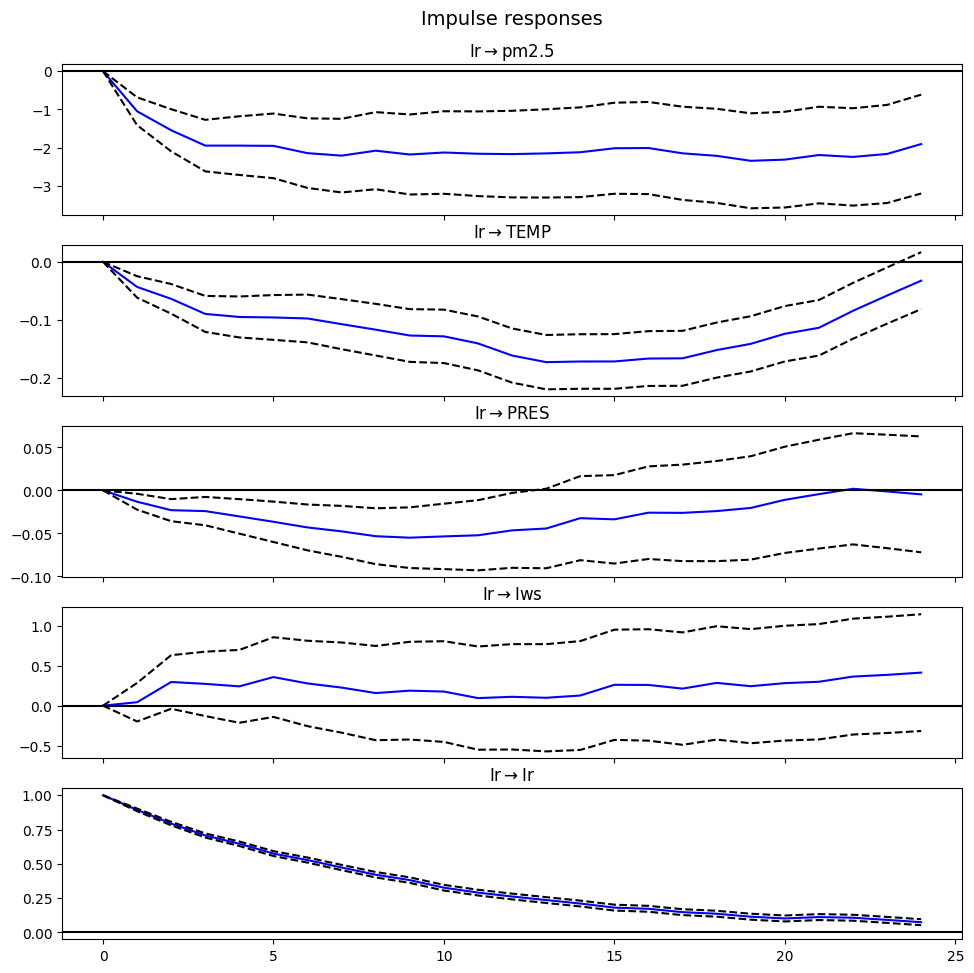

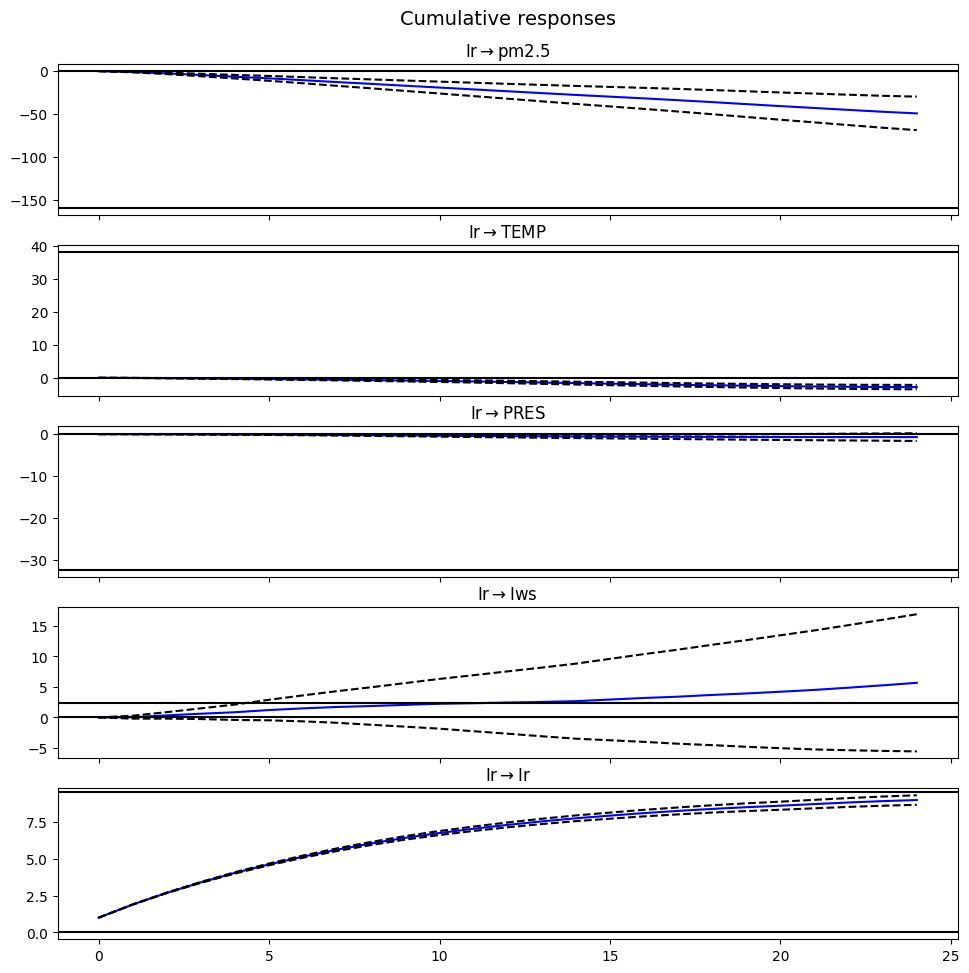

In [59]:
## Impulse Response Functions (IRFs)

# Recreate our VAR model (though we can also use VARMAX models) with rainfall as a variable
# Select variables for VAR model
varData = data[['pm2.5','TEMP','PRES','Iws', 'Ir']].dropna()[:-50]

model = sm.tsa.VAR(varData) # define the model and data
modelFit = model.fit(48) 

# Create the impulse response functions
irf = modelFit.irf(24)
plt = irf.plot(impulse="Ir")
plt.show()

# Create the cumulative response functions
plt2 = irf.plot_cum_effects(impulse="Ir")
plt2.show()

In [60]:
## VARMA (VAR with Moving Average)

# Select variables for VARMA model
varData = data[['pm2.5','TEMP','PRES','Iws']].dropna()[-500:-50]

# Determining Proper Order of Lags (to be used)
model = VARMAX(varData, order=(10,10)) # No order selection helper exists; using VARMAX function without 'exog'
modelFit = model.fit() 
modelFit.summary()

# Caveats
# VARMA is deprecated / effectively removed in modern statsmodels
# It exists only in older versions
# #It is unstable, slow, and not recommended
# In recent statsmodels, it’s not exposed by default

C:\Users\jungm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.

C:\Users\jungm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



KeyboardInterrupt: 

In [ ]:
## VARMAX (VARMA with eXogenous regressors) 

# Prep our data
varData = data[['pm2.5','TEMP','PRES','Iws', 'DEWP']].dropna()[-500:-50]
exog = varData['DEWP']
varData.drop('DEWP', axis=1, inplace=True)

# Create and fit model
model = sm.tsa.VARMAX(endog = varData.values, exog=exog.values, order=(10,0)) # define the order here for VARMAX!'(AR, MA)'
modelFit = model.fit() 
modelFit.summary()


22:46:43 - cmdstanpy - INFO - Chain [1] start processing
22:46:48 - cmdstanpy - INFO - Chain [1] done processing
22:46:49 - cmdstanpy - INFO - Chain [1] start processing
22:47:02 - cmdstanpy - INFO - Chain [1] done processing
<positron-console-cell-69>:34: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

<positron-console-cell-69>:38: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



,ds,yhat
0,2001-01-01,16135.703561
1,2001-01-02,17604.806954
2,2001-01-03,17623.228642
3,2001-01-04,17416.732894
4,2001-01-05,17992.410431


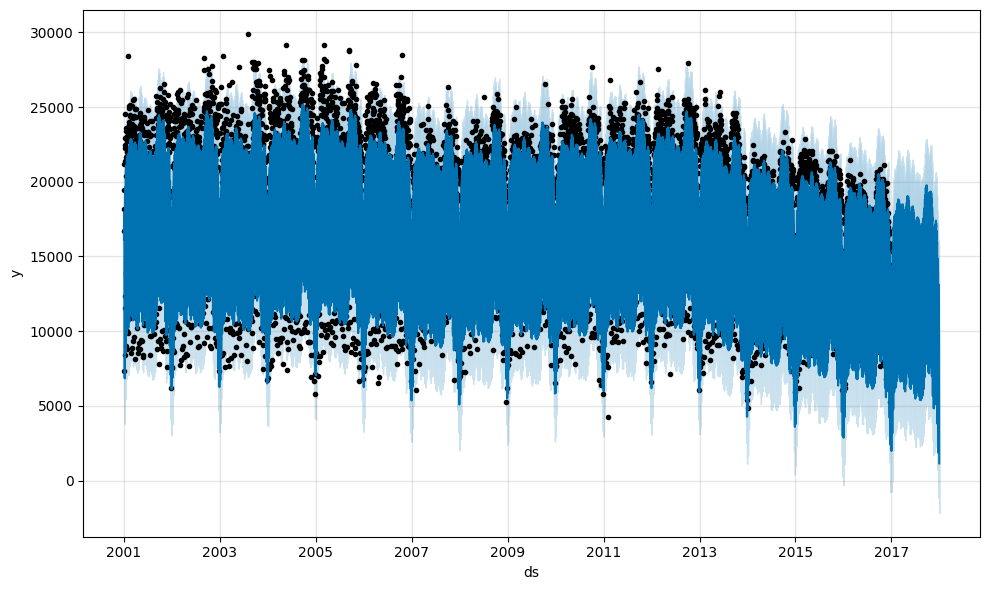

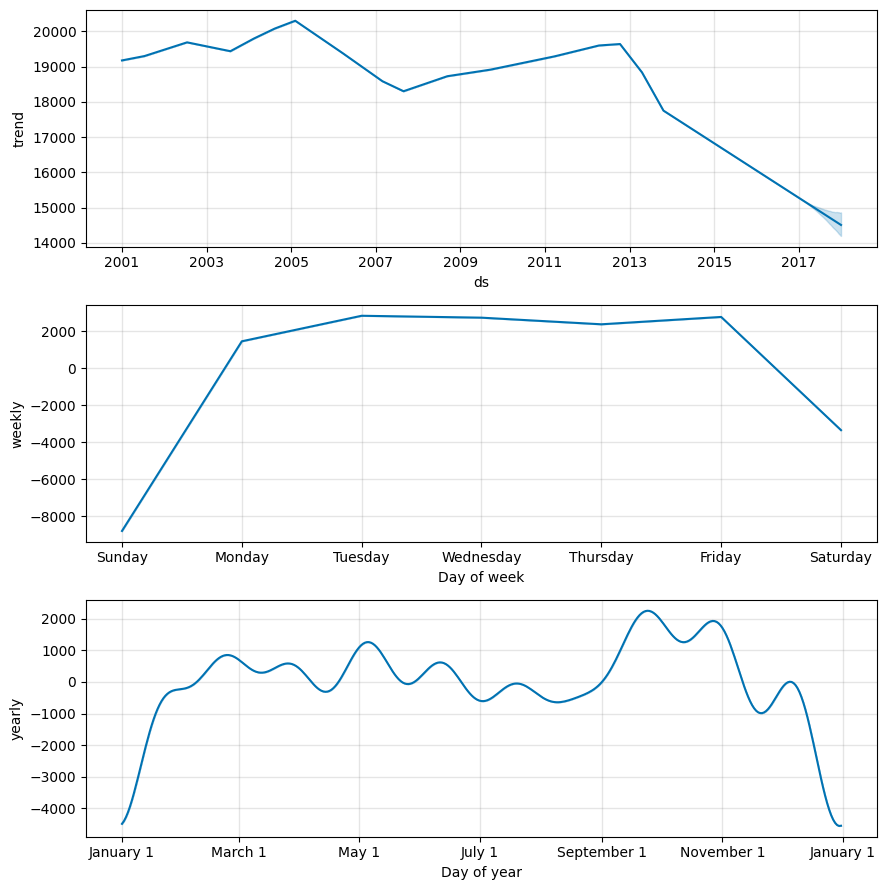

In [ ]:
## Generalized Additive Models (GAMs) with Prophet

data = pd.read_csv("https://github.com/dustywhite7/Econ8310/raw/master/DataSets/chicagoBusRiders.csv")
data.head()

# Prophet is the forecasting built on weekly, yearly, and trend patterns
# So, it's great if you only care about time variables 
# Prophet wants data to be provided in two columns, named ds and y, respectively. 
# ds should contain the timestamp, and y should contain the time series that we want to use.

# Pick up one variable and make it fit to Prophet
data_p = data.loc[data['route']=='3', ['date', 'rides']] #bus route 3, date and values
data_p.columns = ['ds', 'y']
data_p.head()

# Create and fit model
m = Prophet()
m.fit(data_p)

# Using changepoint_prior_scale to decide flexibility
# Higher prior values will tend to be more bendy, overfitting
# Lower vales will tend to be more smoother underfitting
m = Prophet(changepoint_prior_scale=0.2)
m.fit(data_p)

# Create an empty dataframe with dates for future periods
# For 1 year in future 
future = m.make_future_dataframe(periods=365)

# Fill in dataframe wtih forecasts of `y` for the future periods
forecast = m.predict(future)
forecast.head()

# Plot our model together with the forecast
fig = m.plot(forecast)
fig.show()

# Plot the components of the forecast
fig = m.plot_components(forecast)
fig.show()

# If we want to explore the raw forecast numbers for our model, we can just use our forecast DataFrame to extract that information:
forecast[['ds','yhat']].head()

In [ ]:
## Generalized Additive Models (GAMs) with pyGAM

# pyGAM allows us to use non-time variables (i.e., other than week, day, year...), which is the key difference from Prophet
# With pyGAM, we do need to do all of the data processing manually, 
# so we are creating the parsed time data using pandas' built-in functions to create columns for year, month, and day of the week. 
# Once we have our data processed, we can fit our model.

data = pd.read_csv("https://github.com/dustywhite7/Econ8310/raw/master/DataSets/chicagoBusRiders.csv")
data_p = data.loc[data['route']=='3']
data_p['date'] = pd.to_datetime(data_p['date'])
data_p['year'] = data_p['date'].dt.year
data_p['month'] = data_p['date'].dt.month
data_p['day'] = data_p['date'].dt.weekday
data_p.head()

x = data_p[['year', 'month', 'day']]
y = data_p['rides']

# Creating model
# When we imported pyGAM, we also imported s, f, and l. 
# s stands for spline, and represents our most general functional form. 
# Splines can be used to estimate functions of any shape, and so they are the key component of a GAM as enablers of highly flexible functional form.
# f creates a factor-based functional form, and is useful where data is encoded as numbers which are categorial (rather than ordinal) in nature. 
# This allows us to see the different level effects of each encoded factor in the column
# l creates a linear functional form. 
# This can be useful where we expect the relationship between and by constraining the relationship to be linear rather than smooth. 
# Remember that linear functional forms are by far the easiest to interpret, so we want to use them wherever they are representative of truth!
gam = LinearGAM(s(0) + s(1) + f(2))
gam = gam.gridsearch(x.values, y)

# Name each figure
titles = ['year', 'month', 'day']

# Create the subplots in a single-row grid
fig = tools.make_subplots(rows=1, cols=3, subplot_titles=titles)
# Dictate the size of the figure, title, etc.
fig['layout'].update(height=500, width=1000, title='pyGAM', showlegend=False)

# Loop over the titles, and create the corresponding figures
for i, title in enumerate(titles):
    # Create the grid over which to estimate the effect of parameters
    XX = gam.generate_X_grid(term=i)
    # Calculate the value and 95% confidence intervals for each parameter
    # This will become the expected effect on the dependent variable for a given value of x
    pdep, confi = gam.partial_dependence(term=i, width=.95)
    
    # Create the effect and confidence interval traces (there are 3 total)
    trace = go.Scatter(x=XX[:,i], y=pdep, mode='lines', name='Effect')
    ci1 = go.Scatter(x = XX[:,i], y=confi[:,0], line=dict(dash='dash', color='grey'), name='95% CI')
    ci2 = go.Scatter(x = XX[:,i], y=confi[:,1], line=dict(dash='dash', color='grey'), name='95% CI')

    # Add each of the three traces to the figure in the relevant grid position
    fig.append_trace(trace, 1, i+1)
    fig.append_trace(ci1, 1, i+1)
    fig.append_trace(ci2, 1, i+1)

#Plot the figure
py.iplot(fig)


<positron-console-cell-65>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<positron-console-cell-65>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<positron-console-cell-65>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<positron-console-cell-65>:12: Setting

In [ ]:
## Generalized Additive Models (GAMs) with pyGAM (Another Example)

data = pd.read_csv("https://github.com/dustywhite7/Econ8310/raw/master/DataSets/auto-mpg.csv")
data.head()
titles = ['modelYear', 'acceleration', 'weight', 'horsepower', 'displacement','cylinders']
x = data[titles]
y = data['mpg']

# Creating a factor for cylinders since it is not continuous like the other information
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5))
gam = gam.gridsearch(x.values, y)

# Create the subplots in a single-row grid
fig = tools.make_subplots(rows=2, cols=3, subplot_titles=titles)
# Dictate the size of the figure, title, etc.
fig['layout'].update(height=500, width=1000, title='pyGAM', showlegend=False)

# Loop over the titles, and create the corresponding figures
for i, title in enumerate(titles):
    # Create the grid over which to estimate the effect of parameters
    XX = gam.generate_X_grid(term=i)
    # Calculate the value and 95% confidence intervals for each parameter
    # This will become the expected effect on the dependent variable for a given value of x
    pdep, confi = gam.partial_dependence(term=i, width=.95)
    
    # Create the effect and confidence interval traces (there are 3 total)
    trace = go.Scatter(x=XX[:,i], y=pdep, mode='lines', name='Effect')
    ci1 = go.Scatter(x = XX[:,i], y=confi[:,0], line=dict(dash='dash', color='grey'), name='95% CI')
    ci2 = go.Scatter(x = XX[:,i], y=confi[:,1], line=dict(dash='dash', color='grey'), name='95% CI')

    if i<3:
        fig.append_trace(trace, 1, i+1)
        fig.append_trace(ci1, 1, i+1)
        fig.append_trace(ci2, 1, i+1)
    else:
        fig.append_trace(trace, 2, i-2)
        fig.append_trace(ci1, 2, i-2)
        fig.append_trace(ci2, 2, i-2)

#Plot the figure
py.iplot(fig)

# Forecasts
pred = gam.predict(data.loc[3, titles].values.reshape(1,6))
print(pred)

# "Truth was {0:.2f}, prediction was {1:.2f}, the model was off by {2:.2f}.".format(data.loc[3,'mpg'], float(pred), data.loc[3,'mpg']-float(pred)))`

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:010:00
C:\Users\jungm\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\tools.py:453: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



[15.0731184]
